In [2]:
%reload_ext autoreload
#!pip install -r requirements.txt

In [3]:
%autoreload
from RGAN import RGAN
from utils import *
from trainers import *

trainset = TimeGANDatasetSinus(num=100, seq_len=100, features=3, temporal=True)
testset = TimeGANDatasetSinus(num=300, seq_len=100, features=3, temporal=True)
print(len(trainset))
print(trainset[0][0].size())


100
torch.Size([100, 3])


In [ ]:
run = neptune.init_run(
    project="kohmann/timeGAN",
    name="timegan_cnn_DG",
    tags=["cnn","DG"],
    description="flipped to:  mse(H[:, :-1, :], H_hat_supervise[:, 1:, :])",
    source_files=["timegan_cnn_DG.py"],
    capture_hardware_metrics=False,
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjFjNGY5MS1kOWU1LTRmZjgtOTNiYS0yOGI2NDdjZGYzNWUifQ==",
)

In [4]:
%autoreload
import neptune.new as neptune
import torch




device = "cuda" if torch.cuda.is_available() else "cpu"

params = {
    "model_name": "model_rgan.pt",
    "n_epochs": 600,
    "l_rate": 0.0001,
    "batch_size": 32,
    "num_layers": 2,
    "hidden_dim": 20,
    "Z_dim": 100,
    "dis_thresh": 0.15,
    "dataset": "sinus",
    "padding_value": 0.,
    "feature_dim": trainset[0][0].size(1),
    "max_seq_len": trainset[0][0].size(0),
    "trainset_size": len(trainset),
    "device": device,
    "optimizer": "Adam",
}
run["parameters"] = params

model = RGAN(params)

rgan_trainer(model,
                trainset,
                batch_size=params["batch_size"],
                device=torch.device(params["device"]),
                learning_rate=params["l_rate"],
                n_epochs=params["n_epochs"],
                max_seq_len=params["max_seq_len"],
                dis_thresh=params["dis_thresh"],
                neptune_logger=run,
                model_name=params["model_name"]
                )
# Generate random synthetic data
gen_z = rgan_generator(model, torch.tensor(testset.T), params["model_name"], torch.device(device), testset[0][0].size(0), 100)

log_visualizations(testset, gen_z, run) # logs pca, tsne, umap, mode_collapse
run["model_checkpoint"].upload(params["model_name"])

run.stop()


Start Training


Epoch: 9, G: 0.6816, D: 1.3772: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Training Complete and model_rgan.pt saved

Generating Data...Done


In [6]:
params["device"]

'cpu'

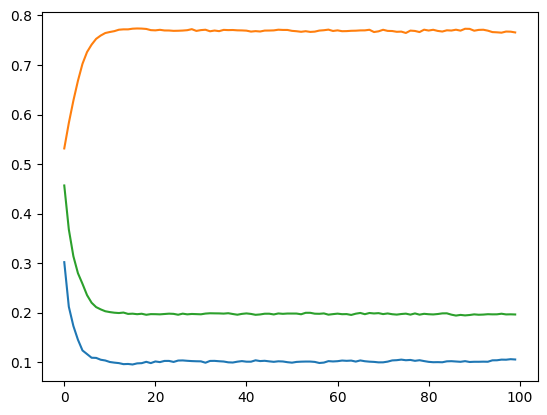

In [8]:
plt.plot(gen_z[0]);